# Implementation: Part I - Initial guess $\eta_0$

In previous parts we have introduced the original problem and through various modifications and mathematical tools reduced the problem to a nice, hopefully solvable form. In this part we will go through finding a suitable initial guess $\eta_0$, which is used in the next part to find the optimal solution $\eta$.

As a reminder, we want to find an initial guess $\eta_0$, which satisfies the boundary constraint $d\eta_0 = \delta_\Gamma$ and the cohomology constraints $\int_M dx_i \wedge \star \eta_0 = A_i, i = 1, 2, 3$.

## How to find the initial guess?

As the original authors describe, the initial guess can be found by first creating the 2-form $\delta_\Gamma$ as a discrete field on $M = \mathbb{T}^3$.  
From that 2-form, one can find the 1-form with $d\eta_0 = \delta_\Gamma$ by solving the Biot-Savart equations for an auxiliary 2-form $\mathbf{\psi}$.

Adding the cohomology constraints is then just a simple addition to the 1-form $\eta_0$ by computing the area vector $\mathbf{A} = \oint \gamma \times d\gamma$ and adding the global shift to $\eta_0$.

Finally, the 1-form $\eta_0$ is discretized as a vector field $X_0$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from src.grid import Grid
from src.compute_initial_guess import compute_initial_guess
from src.utils.curve_generator import ellipse_function

In [2]:
# Curve parameterization
gamma = lambda t: ellipse_function(t, a = 0.3, b = 0.3, base_point=np.array([0.5, 0.5, 0.5]))

Some utility classes and functions are made to make it easier to implement the different steps, including a Grid class and some ellipse functions for creating boundary curves.

In [3]:
# Grid instantiation
grid = Grid(resolution=32)

The code inside `compute_initial_guess` implements most of the heavy lifting, it follows quite directly the steps in Algorithm 5 of the original paper.
The steps are as follows:
1. For each point $p \in M$, compute the flux through the xy, xz, and yz oriented faces.
2. From fluxes, compute the discrete 2-form $\delta_\Gamma$ which represents the curve and store its dual 1-form as object of type `DifferentialForm`
3. From this 2-form, calculate the auxiliary 2-form $\psi$ using the decoupled Poisson equations (equation 35 of the paper)
4. Calculate the codifferential $\star d \star \psi$ to obtain $\tilde{\eta}_0$
5. Add cohomology constraints, finally obtain $\eta_0$
5. Return $X_0$ as the underlying vector field of $\eta_0$

In [4]:
# Computation of initial guess using the implementation
results = compute_initial_guess(grid = grid, gamma = gamma)
eta_0 = results['eta_0']
X_0 = results['X_0']

In [5]:
%%manim -ql -v WARNING -o eta_0_tilde.mp4 scene_eta_0_tilde
scene_eta_0_tilde = build_vector_field_scene(grid, results['eta_tilde'], curve_function=gamma, streak_scaling = 2000)

Manim Community v0.19.0

The initial guess $\tilde{\eta}_0$ corresponds to a nice Biot-Savart field, familiar as the electromagnetic field for a path of electrical current.

## Area correction 
Below is the cohomology corrected field $\eta_0$.   
As long as the input curve $\Gamma$ does not go through the boundaries of the unit box, the surface represented by $\eta_0$ should be able to be embedded in $\mathbb{R}^3$, not just in $\mathbb{T}^3$. As described in the earlier posts and in the original paper, this eliminates the artifacts created by solving the differential equations on a 3-torus, a requirement of using FFT.

In [6]:
%%manim -ql -v WARNING -o eta_0.mp4 scene_eta_0
scene_eta_0 = build_vector_field_scene(grid, results['eta_0'], curve_function=gamma, streak_scaling = 5)

Manim Community v0.19.0

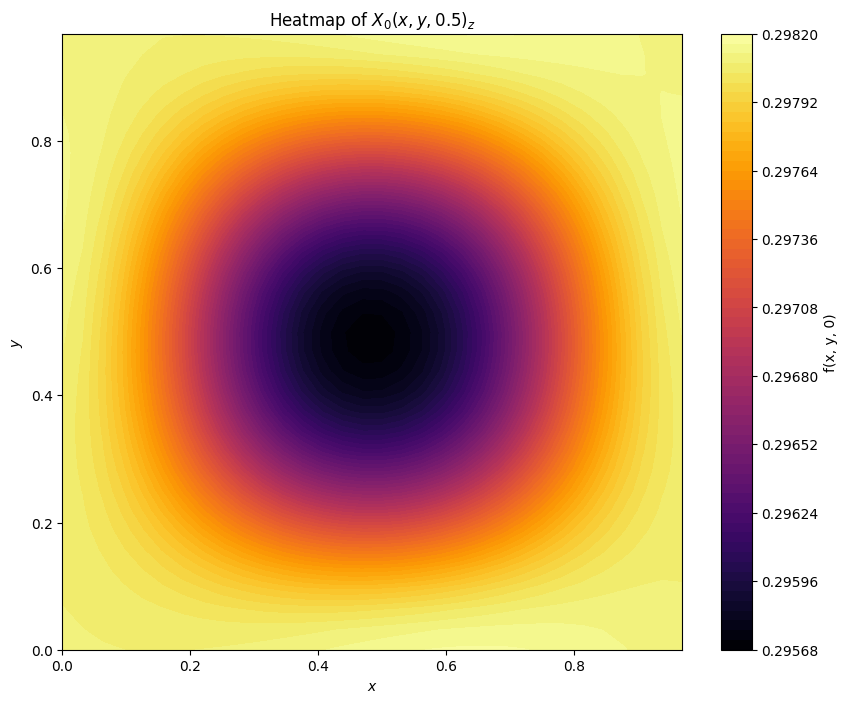

In [15]:
fig = plt.subplots(1, 1, figsize=(10, 8))
plt.contourf(grid.get_grid_positions()[:, :, 0, 0], grid.get_grid_positions()[:, :, 0, 1], X_0[:, :, grid.res[0] // 2, 2], levels=64, cmap='inferno')
plt.colorbar(label='f(x, y, 0)')
plt.title('Heatmap of $X_0(x, y, 0.5)_z$')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

The above plot displays the z-component of $X_0$ at the level of the boundary circle.  
Component in z-direction is less inside the circle than outside, indicating that $X_0$ correctly encodes the information about the surface as an impulse.

# Optimization


After finding the initial guess, we can optimize the surface to have the minimal area, while maintaining the boundary constraint.

In [12]:
eta_field = np.random.normal(size = eta_0.field.shape)
eta = DifferentialForm(grid = grid, field=eta_field, form_degree=1)

In [13]:
# Find scalar potential phi such that eta = eta_0 + d(phi)
def optimize_phi(grid: Grid, lambda_hat: np.array, eta_0: DifferentialForm, eta: DifferentialForm, tau: float = 0.1) -> np.array:
    assert tau > 0, "hyperparameter tau should be positive."

    # From optimality condition, define helper form Y from which we compute the codifferential (codivergence)
    Y_field = eta.field - eta_0.field - (1 / tau) * lambda_hat
    D_Y = DifferentialForm(grid = grid, field = Y_field, form_degree=1).codifferential_fourier(alpha = 0.001)

    # Solve poisson equation
    return eta.fft_poisson_solve(D_Y.field)

lambda_hat = np.zeros_like(eta.field)
phi = optimize_phi(grid = grid, lambda_hat=lambda_hat, eta=eta, eta_0=eta_0)
eta = DifferentialForm(grid = grid, form_degree=1, field=phi.exterior_derivative().field + eta_0.field)

In [14]:
%%manim -ql -v WARNING -o eta.mp4 scene_eta
scene_eta = build_vector_field_scene(grid, eta, curve_function=gamma, streak_scaling = 10)

Manim Community v0.19.0

## Next steps

In the next post, we will go through implementing the optimization routine for finding the optimal surface, the one with least area, from the initial guess $\eta_0$. After that we have a complete implementation of the optimization process.

The only final touch we will add then is to find the actual surface from the optimized 1-form $\eta$.